# IMPORT DATASET FROM CSV

In [3]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

def load_raw_dataset(filename='full_set.csv'):
    df = pd.read_csv(filename)
    from sklearn.utils import shuffle
    #np.random.seed()
    df = shuffle(df, random_state =42)
    return df
    
raw_dataset = load_raw_dataset()
raw_dataset.head(10)


,uic_1,country_1,name_1,lon_1,lat_1,uic_2,country_2,name_2,lon_2,lat_2,match
7785,8022812,DE,Ebersdorf(b Coburg),501327N,110352E,8022813,DE,SCHNEY,500958N,110425E,0
8692,8101182,AT,Fritzens-Wattens,471807N,113519E,8101182,AT,FRITZENS WATTENS,471807N,113520E,1
7799,8023179,DE,Leipzig Hbf,512047N,122300E,8023481,DE,WURZEN,512151N,124420E,0
18177,8744315,FR,VERFEIL LES FENOUILLES,433924N,014008E,8744317,FR,TOULOUSE ROSERAIE,433712N,012810E,0
25203,87G0132,FR,PARC MUNICIPAL,444949N,003137W,871A160,FR,CRANCEY,483054N,033825E,0
4783,7400620,SE,Charlottenberg,595303N,121752E,7400621,SE,CHARLOTTENBERG GRANSEN,595106N,121446E,0
26200,8884350,BE,Thulin,502524N,034445E,8884350,BE,THULIN,502523N,034442E,1
23173,8772232,FR,STE COLOMBE LES VIENNE,453139N,045153E,8772240,FR,GIVORS VILLE,453506N,044556E,0
15311,8721544,FR,Sarrewerden,485521N,070513E,8721545,FR,SARRE UNION,485608N,070506E,0
8729,8101235,AT,Frastanz,471312N,093821E,8101236,AT,FELDKIRCH,471430N,093615E,0


### DEFINE LEVENSTEIN METRIC

Since dataset is huge, apply memory buffer trick

In [4]:
def call_counter(func):
    def helper(*args, **kwargs):
        helper.calls += 1
        return func(*args, **kwargs)

    helper.calls = 0
    helper.__name__ = func.__name__
    return helper


def memorize(func):
    mem = {}

    def memoizer(*args, **kwargs):
        key = str(args) + str(kwargs)
        if key not in mem:
            mem[key] = func(*args, **kwargs)
        return mem[key]

    return memoizer


@call_counter
@memorize
def levenshtein(s, t):
    if s == "":
        return len(t)
    if t == "":
        return len(s)
    if s[-1] == t[-1]:
        cost = 0
    else:
        cost = 1

    res = min([levenshtein(s[:-1], t) + 1,
               levenshtein(s, t[:-1]) + 1,
               levenshtein(s[:-1], t[:-1]) + cost])
    return res

### DEFINE SIMILARITY_VECTOR CLASS
OOP style, but in general ML has procedural approach

In [5]:
from math import sin, cos, sqrt, atan2, radians
import unicodedata as ud

class SimilarityVector:
    def __init__(self):
        self.uic = 0
        self.country_similarity = 0
        self.name_distance = 0
        self.geo_distance = 0

    def set_uic(self, uic1, uic2):
#         self.uic = 0
#         if(levenshtein(str(uic1), str(uic2))) < 3:
#             self.uic = 1
            
        self.uic = levenshtein(str(uic1), str(uic2))

    def set_country(self, country1, country2):
        if country1 == country2:
            self.country_similarity = 1
        else:
            self.country_similarity = 0

    def set_name_distance(self, name1, name2):

        self.name_distance = levenshtein(self.__normalize_string(name1),
                                         self.__normalize_string(name2))

    def set_geo_distance(self, lat1, lon1, lat2, lon2):
        radius_earth = 6373.0
        
        
        lat1 = radians(self.__normalize_geopos(lat1))
        lon1 = radians(self.__normalize_geopos(lon1))
        lat2 = radians(self.__normalize_geopos(lat2))
        lon2 = radians(self.__normalize_geopos(lon2))

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = radius_earth * c

        self.geo_distance = distance
        
    def __normalize_geopos(self, geopos):
           
        h = int(geopos[0:2])
        m = int(geopos[2:4])/60
        s = int(geopos[4:6])/3600
        
        res = h + m + s
               
        return res

    def __normalize_string(self, input):
        input = input.lower()
        input = ''.join(c for c in input if c not in ",-' ")
        input = ud.normalize('NFC',input)

        return str(input)


### TRANSFORM RAW DS INTO VECTOR DS ###
Leave all data (outliers) so no cheating against 1A generic algo

In [6]:
#!!!

dataset_x = pd.DataFrame(columns=['uic_similarity','country_similarity','name_distance','geo_distance'])
dataset_y = pd.DataFrame(columns=['match'])
for index, frame in raw_dataset.iterrows():
   
    vector = SimilarityVector()    
    vector.set_uic(frame[0],frame[5])
    vector.set_country(frame[1],frame[6])
    vector.set_name_distance(str(frame[2]),str(frame[7]))
    vector.set_geo_distance(frame[3],frame[4],frame[8],frame[9])
    
    ### THROW OUT OUTLIERS ###
    #if vector.geo_distance > 250 and frame[10] == 1:
    #    continue
        
    #if vector.name_distance + vector.uic > 10 and frame[10] == 1:
    #    continue
    
    dataset_x = dataset_x.append({
        "uic_similarity": vector.uic,
        "country_similarity": vector.country_similarity,
        "name_distance": vector.name_distance,
        "geo_distance": vector.geo_distance,
          }, ignore_index=True)
    
    dataset_y = dataset_y.append({"match": frame[10],}, ignore_index=True)

In [7]:
### REMOVE NaN, Inf, etc ###

# def clean_dataset(df):
#     assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
#     df.dropna(inplace=True)
#     indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
#     return df[indices_to_keep].astype(np.float64)

# clean_dataset(dataset_x)

dataset_x.head(8)

,uic_similarity,country_similarity,name_distance,geo_distance
0,1.0,1.0,16.0,6.490415
1,0.0,1.0,0.0,0.020952
2,3.0,1.0,9.0,24.776559
3,1.0,1.0,16.0,16.564833
4,4.0,1.0,10.0,473.652689
5,1.0,1.0,7.0,4.625005
6,0.0,1.0,0.0,0.066649
7,2.0,1.0,14.0,10.027846


# VISUALISE DATASET

Trying to imply some relations in data

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

dataset_x_raw = dataset_x.values.tolist()

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

xs_true, ys_true, zs_true = list(), list(), list()
for i,label in dataset_y.iterrows():
    if label['match'] == 1:        
        xs_true.append(dataset_x_raw[i][0])
        ys_true.append(dataset_x_raw[i][2])
        zs_true.append(dataset_x_raw[i][3])
        
ax.scatter(xs_true, ys_true, zs_true, s=50, alpha=0.7, edgecolors='w', color="g")

xs_false, ys_false, zs_false = list(), list(), list()
for i,label in dataset_y.iterrows():
    if label['match'] == 0:        
        xs_false.append(dataset_x_raw[i][0])
        ys_false.append(dataset_x_raw[i][2])
        zs_false.append(dataset_x_raw[i][3])
        
ax.scatter(xs_false, ys_false, zs_false, s=50, alpha=0.1, edgecolors='w', color="r")

ax.set_xlabel('uic_similarity', size="24")
ax.set_ylabel('name_distance', size="24")
ax.set_zlabel('geo_distance', size="24")

ax.set_zlim([0, 2000])

plt.show()

<Figure size 1600x1200 with 1 Axes>

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

dataset_x_raw = dataset_x.values.tolist()

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

xs_true, ys_true, zs_true = list(), list(), list()
for i,label in dataset_y.iterrows():
    if label['match'] == 1:        
        xs_true.append(dataset_x_raw[i][0])
        ys_true.append(dataset_x_raw[i][2])
        zs_true.append(1)
        
ax.scatter(xs_true, ys_true, zs_true, s=90, alpha=0.01, edgecolors='w', color="g")

xs_false, ys_false, zs_false = list(), list(), list()
for i,label in dataset_y.iterrows():
    if label['match'] == 0:        
        xs_false.append(dataset_x_raw[i][0])
        ys_false.append(dataset_x_raw[i][2])
        zs_false.append(0)
        
ax.scatter(xs_false, ys_false, zs_false, s=90, alpha=0.01, edgecolors='w', color="r")

ax.set_xlabel('uic_similarity', size="24")
ax.set_ylabel('name_distance', size="24")
ax.set_zlabel('match', size="24")

plt.show()

# RESCALE DATA TO STANDART RANGE

Because some ML models don't tolerate different scale of features

In [45]:
from sklearn.preprocessing import normalize, scale, MinMaxScaler

scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(dataset_x.values)
dataset_x = pd.DataFrame(scaled_x)
#normalize(dataset_x, copy=False, axis=1)
dataset_x.head(8)

,0,1,2,3
0,0.142857,1.0,0.592593,0.001253
1,0.000000,1.0,0.000000,0.000004
2,0.428571,1.0,0.333333,0.004783
3,0.142857,1.0,0.592593,0.003198
4,0.571429,1.0,0.370370,0.091439
5,0.142857,1.0,0.259259,0.000893
6,0.000000,1.0,0.000000,0.000013
7,0.285714,1.0,0.518519,0.001936


In [ ]:
dataset_x.shape

In [ ]:
dataset_y.shape

In [ ]:
dataset_y.head(8)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

dataset_x_raw = dataset_x.values.tolist()

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

xs_true, ys_true, zs_true = list(), list(), list()
for i,label in dataset_y.iterrows():
    if label['match'] == 1:        
        xs_true.append(dataset_x_raw[i][0])
        ys_true.append(dataset_x_raw[i][2])
        zs_true.append(dataset_x_raw[i][3])
        
ax.scatter(xs_true, ys_true, zs_true, s=50, alpha=0.7, edgecolors='w', color="g")

xs_false, ys_false, zs_false = list(), list(), list()
for i,label in dataset_y.iterrows():
    if label['match'] == 0:        
        xs_false.append(dataset_x_raw[i][0])
        ys_false.append(dataset_x_raw[i][2])
        zs_false.append(dataset_x_raw[i][3])
        
ax.scatter(xs_false, ys_false, zs_false, s=50, alpha=0.1, edgecolors='w', color="r")

ax.set_xlabel('uic_similarity', size="24")
ax.set_ylabel('name_distance', size="24")
ax.set_zlabel('geo_distance', size="24")

# ax.set_xlim([0, 2])
# ax.set_ylim([0, 1])
ax.set_zlim([0, 0.4])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(611)

xs_true, ys_true, = list(), list()
for i,label in dataset_y.iterrows():
    xs_true.append(dataset_x_raw[i][0])
    ys_true.append(label['match'])
        
ax.scatter(xs_true, ys_true, s=240, alpha=0.005, edgecolors='white', color="gray")

ax.set_xlabel('uic_similarity', size="24")
ax.set_ylabel('match/no match', size="24")


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(611)

xs_true, ys_true, zs_true = list(), list(), list()
for i,label in dataset_y.iterrows():
    xs_true.append(dataset_x_raw[i][2])
    ys_true.append(label['match'])
        
ax.scatter(xs_true, ys_true, s=240, alpha=0.005, edgecolors='white', color="gray")

ax.set_xlabel('name_distance', size="24")
ax.set_ylabel('match/no match', size="24")


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(611)

xs_true, ys_true, zs_true = list(), list(), list()
for i,label in dataset_y.iterrows():
    xs_true.append(dataset_x_raw[i][3])
    ys_true.append(label['match'])
        
ax.scatter(xs_true, ys_true, s=50, alpha=0.1, edgecolors='white', color="gray")

ax.set_xlabel('geo_distance')
ax.set_ylabel('match/no match')


# SPLIT DATASET TEST/TRAIN

## 75 / 25 %

!!! go to slides "Train, Validate, Test!"

In [46]:
div = 18000

X_train, X_test, y_train, y_test = dataset_x[:div], dataset_x[div:],dataset_y[:div], dataset_y[div:]
y_train=y_train.astype('int')

In [11]:
#Define utility function
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def print_scoring_matrix(y_train, y_pred_array, final=False):
    
    p_score = precision_score(y_train, y_pred_array)
    r_score = recall_score(y_train, y_pred_array)
    f1 = f1_score(y_train, y_pred_array)
    auc_score = roc_auc_score(y_train, y_pred_array)
    
    fig = plt.figure(figsize=(8, 4))
    ax_p = fig.add_subplot(221)
    ax_r = fig.add_subplot(222)
    ax_f1 = fig.add_subplot(223)
    ax_auc = fig.add_subplot(224)
    
   
    
    # these are matplotlib.patch.Patch properties
    if final:
        props = dict(boxstyle='square', facecolor='g', alpha=0.5)
    else:
        props = dict(boxstyle='square', facecolor='w', alpha=0.5)

    # place a text box in upper left in axes coords
    ax_p.text(0, 0, r'$\ Prc=%.4f$' % (p_score, ),
              transform=ax_p.transAxes, fontsize=24, verticalalignment='top', bbox=props)
    ax_r.text(0, 0, r'$\ Rcl=%.4f$' % (r_score, ),
              transform=ax_r.transAxes, fontsize=24, verticalalignment='top', bbox=props)
    ax_f1.text(0, 0.7, r'$\ F1s=%.4f$ ' % (f1, ),
              transform=ax_f1.transAxes, fontsize=24, verticalalignment='top', bbox=props)
    ax_auc.text(0, 0.7, r'$\ Auc=%.4f$' % (auc_score, ),
              transform=ax_auc.transAxes, fontsize=24, verticalalignment='top', bbox=props)
    
    
    ax_p.set_axis_off()
    ax_r.set_axis_off()
    ax_f1.set_axis_off()
    ax_auc.set_axis_off()

    plt.show()

# ............................ 

# SGDClassifier and estimation

!!! Go to slides SGDClassifier!

In [15]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="log", max_iter=5, alpha=0.5, random_state=42)
sgd_clf.fit(X_train, y_train.values.ravel())

SGDClassifier(alpha=0.5, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train.values.ravel(), cv=3, scoring="roc_auc")

array([0.97551471, 0.97363026, 0.9720063 ])

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train.values.ravel(), cv=3)

from sklearn.metrics import confusion_matrix

In [18]:
#define utility function
import itertools
def plot_confusion_matrix(y_test, y_pred, classes,                          
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    plt.figure()
    plt.rcParams["figure.figsize"]=16,8
    
    cm_normalized = cm.astype('float')*100 / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size="24")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment='bottom',
                 size="24",
                 color="white" if cm[i, j] > thresh else "black")
        
    for i, j in itertools.product(range(cm_normalized.shape[0]), range(cm_normalized.shape[1])):
        plt.text(j, i, format(cm_normalized[i, j], '.1f') + "%",
             horizontalalignment='center',
             verticalalignment='top',
             size="18",
             color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    
    plt.show()

    

In [ ]:
plot_confusion_matrix(y_train.astype('int'), y_train_pred, (0,1), title="SGD @ Train")

In [ ]:
print_scoring_matrix(y_train, y_train_pred)

In [73]:
from sklearn.metrics import precision_recall_curve

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train.values.ravel(), cv=3,
                             method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

y_scores.shape

### Showing P/R Threshold for SGD

In [75]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(16, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-0.1, 0.06])

plt.show()

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "g-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(16, 8))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC_AUC curve for SGD

In [23]:
from sklearn.metrics import roc_curve

In [22]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(16, 8))
plot_roc_curve(fpr, tpr)
plt.show()

NameError: name 'y_scores' is not defined

# Hyperparameter tuning

Grid search

In [53]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#!!!

param_grid={
    'alpha': [0.0001,0.001,0.01],
    'epsilon': [0.01,0.1,1],
    'l1_ratio': [0.01,0.1,0.15],
    'max_iter':[5, 10, 25, 50],
    'penalty':["l1","l2","elasticnet"]
}
 
clf = SGDClassifier(loss="log", random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=3, verbose=3, n_jobs=12, scoring="roc_auc")
grid_search.fit(X_train, y_train.values.ravel())

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(alpha = 0.0001, epsilon = 0.01, penalty="l1", l1_ratio = 0.01, max_iter = 50, random_state=42)
sgd_clf.fit(X_train, y_train.values.ravel())

In [ ]:
y_train_pred = sgd_clf.predict(X_train).astype('int')

plot_confusion_matrix(y_train.astype('int'), y_train_pred, sgd_clf.classes_, title="SDG @ Train (tuned)")

In [ ]:
print_scoring_matrix(y_train, y_train_pred, False)

In [ ]:
y_test_pred = sgd_clf.predict(X_test).astype('int')

plot_confusion_matrix(y_test.astype('int'), y_test_pred, sgd_clf.classes_, title="SDG @ Test (tuned)")

# SDG Test set final estimation


In [ ]:
print_scoring_matrix(y_test.astype('int'), y_test_pred, True)

# ......................

# RandomForestClassifier 

!!! GO to slides "Decision Tree!"

In [83]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=2,
                                    criterion='entropy',
                                    max_depth=1,
                                    min_samples_split=0.3,
                                    min_samples_leaf=9,
                                    n_jobs=12,
                                    min_weight_fraction_leaf=0.15,
                                    max_leaf_nodes=None,
                                    max_features="sqrt",
                                    min_impurity_decrease=0.1,
                                    random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train.values.ravel(), cv=3,
                                    method="predict_proba")
forest_clf.fit(X_train, y_train.values.ravel())

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=1, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.1, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=0.3,
            min_weight_fraction_leaf=0.15, n_estimators=2, n_jobs=12,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
y_train_pred = forest_clf.predict(X_train).astype('int')

plot_confusion_matrix(y_train.astype('int'), y_train_pred, forest_clf.classes_, title="RFC @ Train")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [ ]:
#roc_auc_score(y_train, y_scores_forest)

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train.values.ravel(), cv=3)

In [ ]:
print_scoring_matrix(y_train, y_train_pred_forest)

In [92]:
#!!! Don't rerun (7-10 minutes)


from sklearn.model_selection import GridSearchCV

# param_grid={'n_estimators': [1,2,4,8,16,40,80],
#             'max_leaf_nodes': [None],
#             'max_features': ['auto'],
#             'max_depth': [2,4,6,8],
#             'min_samples_leaf': [1,2,3,4,5],
#             'min_samples_split': [0.1, 0.3,0.5, 2, 4, 8, 20],
#             'criterion': ['gini', 'entropy']            
#            },
param_grid={'n_estimators': [9,10,11],
            'criterion': ['gini', 'entropy']            
           },
clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=3, n_jobs=12, scoring="roc_auc")
grid_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=12)]: Done  18 out of  30 | elapsed:   29.2s remaining:   19.5s
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:   29.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=12,
       param_grid=({'n_estimators': [9, 10, 11], 'criterion': ['gini', 'entropy']},),
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [93]:
grid_search.best_score_

0.9984953596198919

In [94]:
grid_search.best_params_

{'criterion': 'entropy', 'n_estimators': 11}

In [95]:
# forest_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#             max_depth=None, max_features='auto', max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
#             oob_score=False, random_state=42, verbose=0, warm_start=False)
forest_clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)


forest_clf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

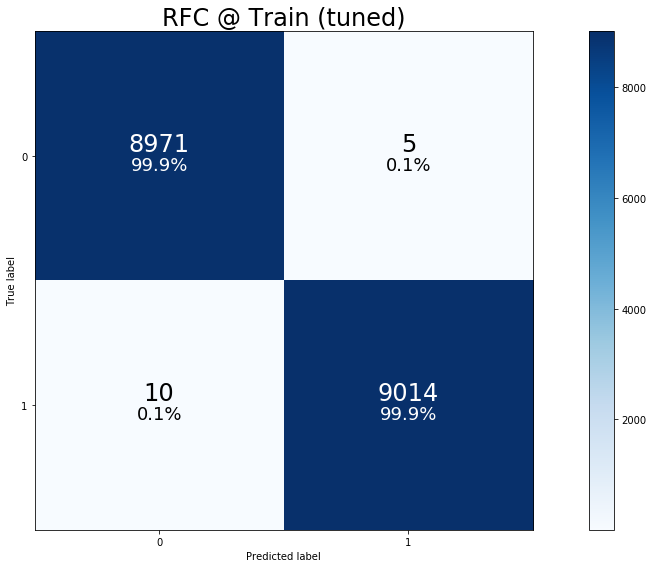

In [96]:
y_train_pred = forest_clf.predict(X_train).astype('int')

plot_confusion_matrix(y_train.astype('int'), y_train_pred, forest_clf.classes_, title="RFC @ Train (tuned)")

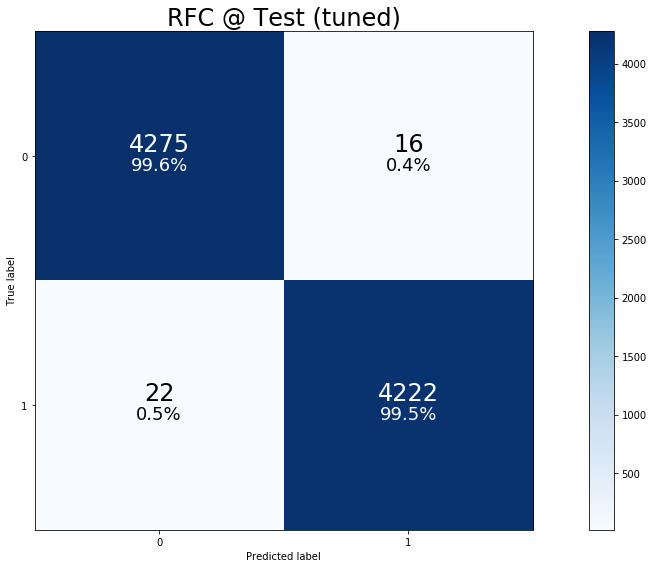

In [97]:
y_test_pred = forest_clf.predict(X_test).astype('int')

plot_confusion_matrix(y_test.astype('int'), y_test_pred, forest_clf.classes_, title="RFC @ Test (tuned)")

# RandomForest Test set final estimation

In [ ]:
print_scoring_matrix(y_test.astype('int'), y_test_pred, True)

# ..............

# SVM Classifier

!!! Go to slides


In [48]:
from sklearn.svm import SVC
svm_clf = SVC(kernel="rbf",
              gamma=0.25,
              max_iter = -1,
              C=20,
              probability=True,
              random_state=42
             )
svm_clf.fit(X_train, y_train.values.ravel())

SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.25, kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
y_probas_svm = cross_val_predict(svm_clf, X_train, y_train.values.ravel(), cv=3,
                                    method="predict_proba")

y_scores_svm = y_probas_svm[:, 1] # score = proba of positive class

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm)

plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plt.legend(loc="lower right", fontsize=16)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


NameError: name 'fpr' is not defined

<Figure size 1152x864 with 0 Axes>

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores_forest)

plt.figure(figsize=(16, 8))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plt.legend(loc="lower right", fontsize=16)

plt.show()

In [ ]:
y_probas_svm = cross_val_predict(svm_clf, X_train, y_train.values.ravel(), cv=3,
                                    method="predict_proba")
y_scores_svm = y_probas_svm[:, 1] # score = proba of positive class
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_train, y_scores_svm)

In [49]:
y_train_pred_svm = cross_val_predict(svm_clf, X_train, y_train.values.ravel(), cv=3)


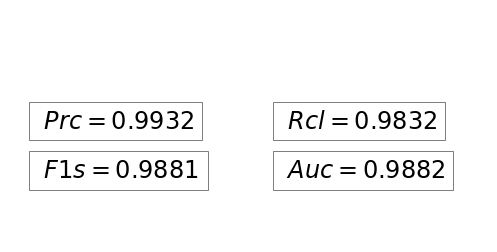

In [50]:
print_scoring_matrix(y_train, y_train_pred_svm)

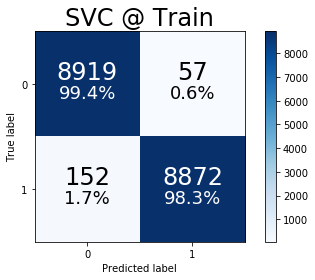

In [51]:
svm_clf.fit(X_train, y_train.values.ravel())

y_train_pred = svm_clf.predict(X_train).astype('int')

plot_confusion_matrix(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train")

In [58]:
!!!Dont restart, takes much time

#param_grid = {'C':[5, 10, 20],'gamma':[0.25,1,3], 'kernel':['rbf']}
param_grid = {'C':[20,25,30],'gamma':[3,4,5], 'kernel':['rbf']}
clf = SVC(random_state=42)


grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=4, n_jobs=8, scoring="roc_auc")
grid_search.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   21.3s
[Parallel(n_jobs=8)]: Done  42 out of  45 | elapsed:   23.7s remaining:    1.6s
[Parallel(n_jobs=8)]: Done  45 out of  45 | elapsed:   23.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [20, 25, 30], 'gamma': [3, 4, 5], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=4)

In [59]:
grid_search.best_params_

{'C': 25, 'gamma': 5, 'kernel': 'rbf'}

In [60]:
grid_search.best_score_

0.9961739800982256

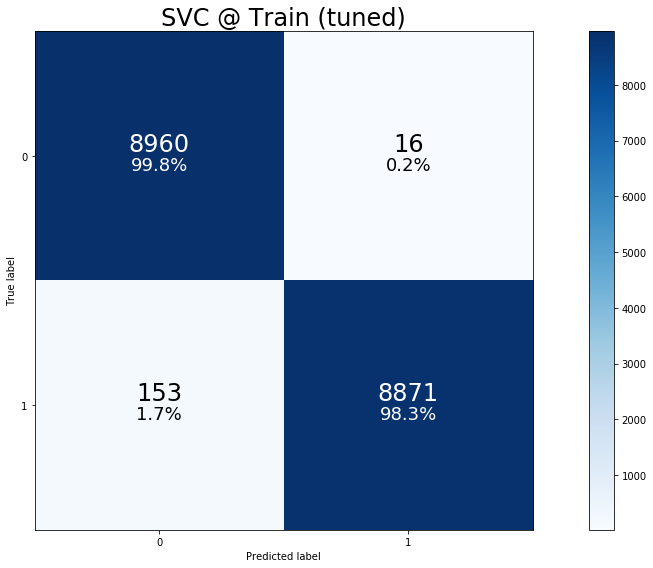

In [61]:
svm_clf = SVC(kernel="rbf", C=20, gamma=3, probability=True)
svm_clf = SVC(kernel="rbf", C=25, gamma=5, probability=True)

svm_clf.fit(X_train, y_train.values.ravel())

y_train_pred = svm_clf.predict(X_train).astype('int')

plot_confusion_matrix(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train (tuned)")

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.metrics import make_scorer, roc_auc_score

mdl = SVC(probability = True, random_state = 42, kernel="rbf")

rand_list = {"C": stats.uniform(35, 20),
             "gamma": stats.uniform(5, 10)}
              
rand_search = RandomizedSearchCV(mdl, param_distributions = rand_list, n_iter = 20,
                                 n_jobs = 8, verbose=6, cv = 3, random_state = 42, scoring = 'precision')

rand_search.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   30.1s
[Parallel(n_jobs=8)]: Done  56 out of  60 | elapsed:   37.0s remaining:    2.6s
[Parallel(n_jobs=8)]: Done  60 out of  60 | elapsed:   37.6s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=8,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000000543F0B8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000038598748>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='precision', verbose=6)

In [67]:
rand_search.best_params_

{'C': 46.84829137724085, 'gamma': 5.4645041271999775}

In [68]:
rand_search.best_score_

0.9975277414593102

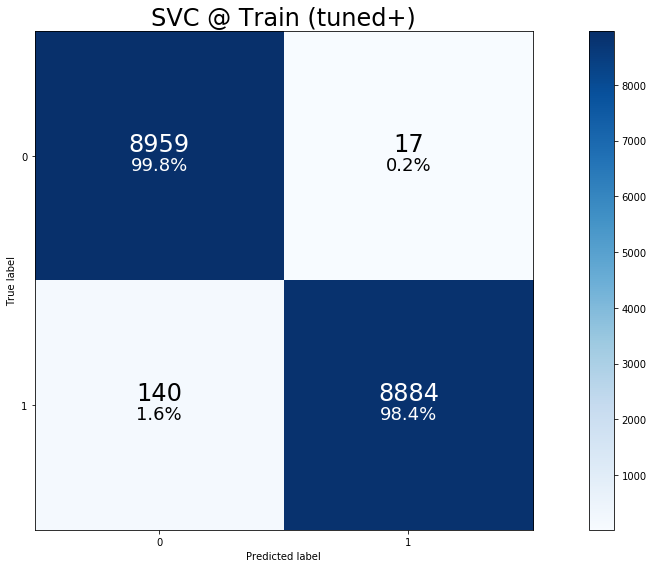

In [69]:
svm_clf = SVC(kernel="rbf", C=46.84, gamma=5.464, random_state=42, probability=True)

svm_clf.fit(X_train, y_train.values.ravel())

y_train_pred = svm_clf.predict(X_train).astype('int')

plot_confusion_matrix(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train (tuned+)")

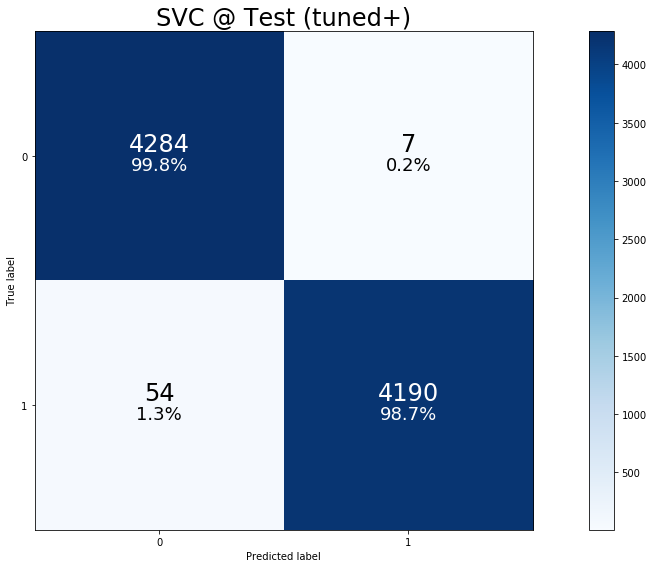

In [70]:
y_test_pred = svm_clf.predict(X_test).astype('int')

plot_confusion_matrix(y_test.astype('int'), y_test_pred, svm_clf.classes_, title="SVC @ Test (tuned+)")

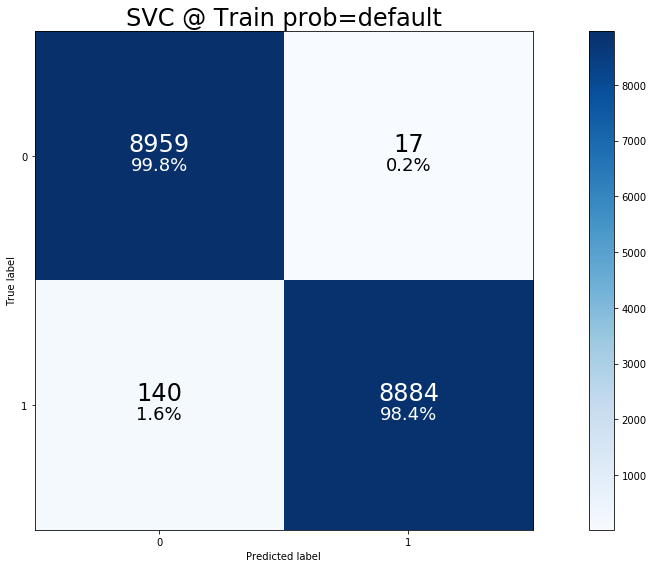

In [71]:
### Tune by PROB ###

y_train_pred = svm_clf.predict(X_train).astype('int')

plot_confusion_matrix(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train prob=default")

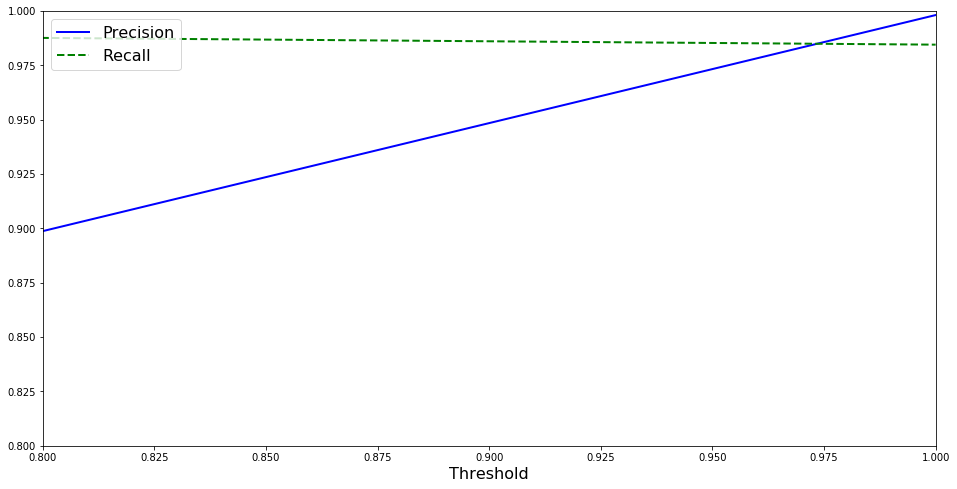

In [76]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred)

plt.figure(figsize=(16, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0.8, 1])
plt.ylim([0.8, 1])

plt.show()

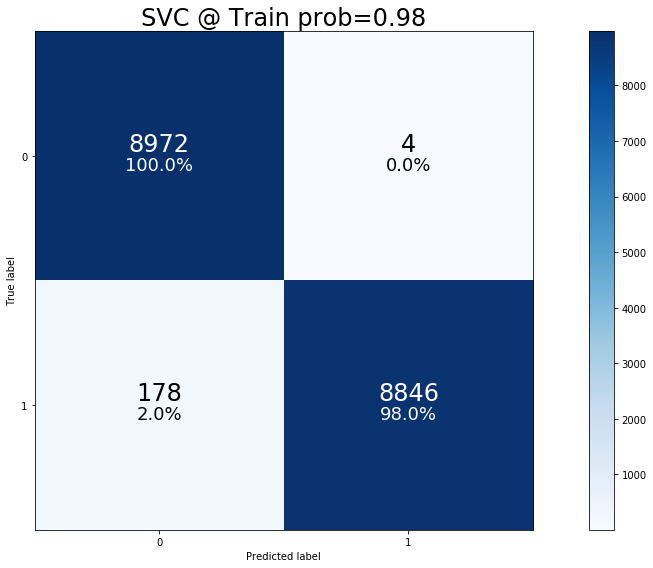

In [80]:
### PROB PREDICTION ###
prob = 0.98
y_train_pred = (svm_clf.predict_proba(X_train)[:,1] >=prob).astype(int)

plot_confusion_matrix(y_train.astype('int'), y_train_pred, svm_clf.classes_, title="SVC @ Train prob=" + str(prob))

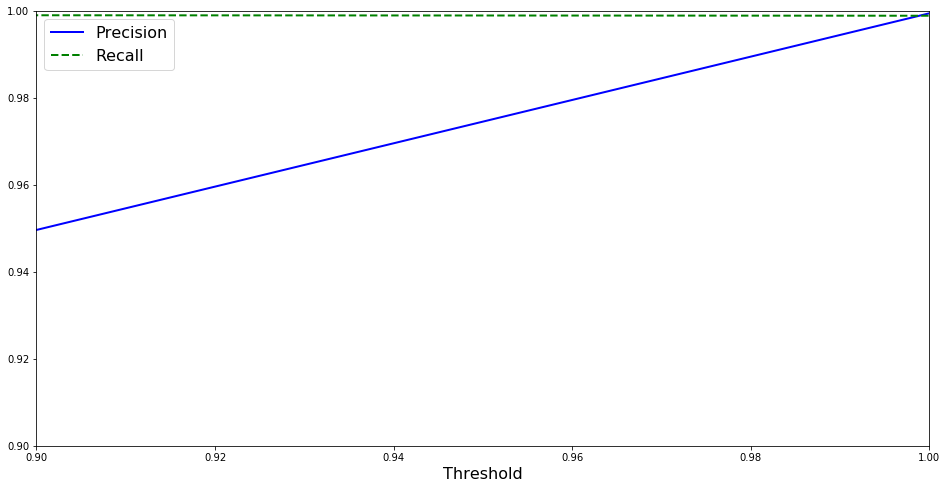

In [98]:
forest_clf.fit(X_train, y_train.values.ravel())

y_train_pred = forest_clf.predict(X_train).astype('int')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred)


plt.figure(figsize=(16, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([0.9, 1])
plt.ylim([0.9, 1])

plt.show()

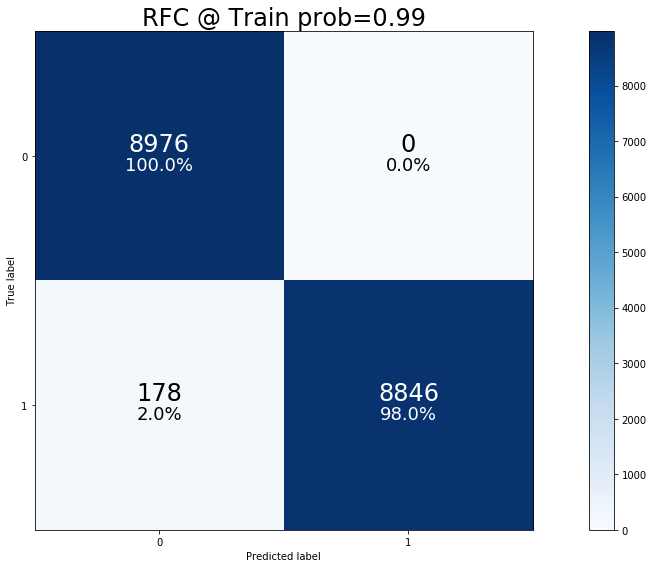

In [103]:
prob = 0.99
y_train_pred = (forest_clf.predict_proba(X_train)[:,1] >= prob).astype(int)

plot_confusion_matrix(y_train.astype('int'), y_train_pred, forest_clf.classes_, title="RFC @ Train prob=" + str(prob))

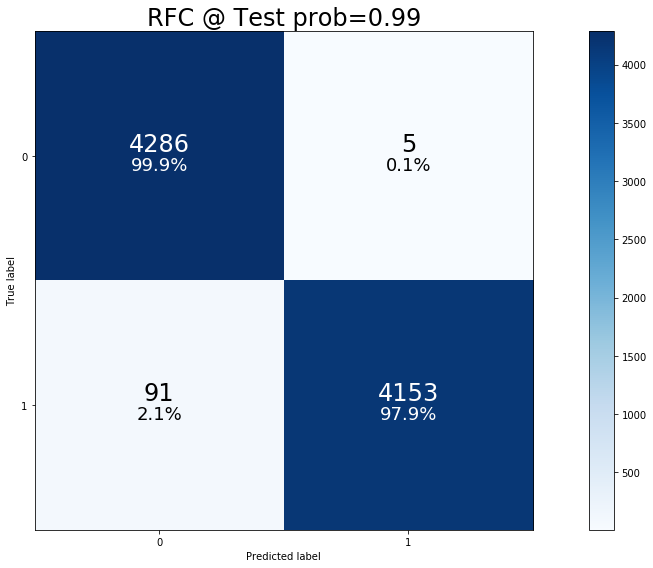

In [105]:
prob = 0.99

y_test_pred = (forest_clf.predict_proba(X_test)[:,1] >= prob).astype(int)

plot_confusion_matrix(y_test.astype('int'), y_test_pred, forest_clf.classes_, title="RFC @ Test prob=" + str(prob))